# ChainerによるWideResNet

## 本チュートリアルではchainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．　環境としてはGoogle が提供する Google Colaboratory上でおこないます． GPU上で処理を行うため，colaboratoryの[ランタイム]->[ランタイムのタイプを変更]からハードウェアアクセラレータをGPUにしてください．

Goolge Colaboratory上にChainerとCupyをインストールします．

In [1]:
!curl https://colab.chainer.org/install | sh -
!pip install 'chainercv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   4128      0 --:--:-- --:--:-- --:--:--  4128
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


Chainerでニューラルネットワークを学習するために必要なモジュールや関数をインポートします．また，data augmentationを行うために，画像変換にopencvを利用します．opencvのモジュールであるcv2も合わせてインポートします．

In [ ]:
import numpy as np
import chainer
from chainer import cuda,optimizers, serializers, Chain, Variable
import chainer.functions as F
import chainer.links as L
from chainer.datasets import TransformDataset
from chainercv import transforms
from functools import partial
import cv2


GPUが利用できるか確認します．

In [3]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


畳み込みニューラルネットワークを定義します．ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．１層目の畳み込み層は入力チャンネル数が１，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．２層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．１つ目の全結合層は入力ユニット数は不定とし，出力は1024としています．次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．これらの各層の構成を\__init\__関数で定義します．
次に，\__call\__関数では，定義した層を接続して処理するように記述します．\__call\__関数の引数xは入力データです．それを\__init\__関数で定義したconv1に与え，その出力を活性化関数であるrelu関数に与えます．そして，その出力をmax_pooling_2dに与えて，プーリング処理結果をhとして出力します．hはconv2に与えられて畳み込み処理とプーリング処理を行います．そして，出力hをl1に与えて全結合層の処理を行います．最終的にl3の全結合層の処理を行った出力hを戻り値としています．


In [ ]:
class WideBasic(chainer.Chain):
    def __init__(self, n_input, n_output, stride, dropout):
        w = chainer.initializers.HeNormal()
        super(WideBasic, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                n_input, n_output, 3, stride, 1, nobias=True, initialW=w)
            self.conv2 = L.Convolution2D(
                n_output, n_output, 3, 1, 1, nobias=True, initialW=w)
            self.bn1 = L.BatchNormalization(n_input)
            self.bn2 = L.BatchNormalization(n_output)
            if n_input != n_output:
                self.shortcut = L.Convolution2D(
                    n_input, n_output, 1, stride, nobias=True, initialW=w)
        self.dropout = dropout

    def __call__(self, x):
        x = F.relu(self.bn1(x))
        h = F.relu(self.bn2(self.conv1(x)))
        if self.dropout:
            h = F.dropout(h)
        h = self.conv2(h)
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        return h + shortcut


class WideBlock(chainer.ChainList):
    def __init__(self, n_input, n_output, count, stride, dropout):
        super(WideBlock, self).__init__()
        self.add_link(WideBasic(n_input, n_output, stride, dropout))
        for _ in range(count - 1):
            self.add_link(WideBasic(n_output, n_output, 1, dropout))

    def __call__(self, x):
        for link in self:
            x = link(x)
        return x


class WideResNet(chainer.Chain):
    def __init__(
            self, widen_factor=10, depth=28, num_classes=10, dropout=True):
        k = widen_factor
        assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
        n = (depth - 4) // 6
        n_stages = [16, 16 * k, 32 * k, 64 * k]
        w = chainer.initializers.HeNormal()
        super(WideResNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                None, n_stages[0], 3, 1, 1, nobias=True, initialW=w)
            self.wide2 = WideBlock(n_stages[0], n_stages[1], n, 1, dropout)
            self.wide3 = WideBlock(n_stages[1], n_stages[2], n, 2, dropout)
            self.wide4 = WideBlock(n_stages[2], n_stages[3], n, 2, dropout)
            self.bn5 = L.BatchNormalization(n_stages[3])
            self.fc6 = L.Linear(n_stages[3], num_classes, initialW=w)

    def __call__(self, x):
        h = self.conv1(x)
        h = self.wide2(h)
        h = self.wide3(h)
        h = self.wide4(h)
        h = F.relu(self.bn5(h))
        h = F.average_pooling_2d(h, (h.shape[2], h.shape[3]))
        return self.fc6(h)


次に学習データを読み込みます．CIFAR10データセットは中規模な一般物体認識のデータセットであり，chainerでは CIFAR10
データセットを取得し，学習するためのフォーマットに変換してくれます．データセットには学習用とテスト用のデータに別れており，それぞれtrain_dataset, test_datasetとします．また，それらには画像データと教師ラベルがあり，それらをtrain_xとtrain_y，test_xとtest_yとします．

In [5]:
#train_dataset, test_dataset = chainer.datasets.get_cifar10(scale=255.)
train_dataset, test_dataset = chainer.datasets.get_cifar10()
mean = np.mean([x for x, _ in train_dataset], axis=(0, 2, 3))
std = np.std([x for x, _ in train_dataset], axis=(0, 2, 3))
print (len(train_dataset), len(test_dataset))

50000 10000


In [ ]:
def transform(  inputs, mean, std, expand_ratio=1.0, crop_size=(32, 32), train=True):
    img, label = inputs
    img = img.copy()

    if train:
        # Random flip
        img = transforms.random_flip(img, x_random=True)
        # Random expand
        if expand_ratio > 1:
            img = transforms.random_expand(img, max_ratio=expand_ratio)
        # Random crop
        if tuple(crop_size) != (32, 32):
            img = transforms.random_crop(img, tuple(crop_size))

    return img, label


In [ ]:
train_transform = partial( transform, mean=mean, std=std, expand_ratio=1.2, crop_size=[28, 28], train=True)
valid_transform = partial(transform, mean=mean, std=std, train=False)

train_dataset = TransformDataset(train_dataset, train_transform)
test_dataset = TransformDataset(test_dataset, valid_transform)


畳み込みネットワークモデルを定義します．ここでは，GPUで学習を行うために，modelをGPUに送るto_gpu関数を利用しています．学習を行う際の最適化方法としてモーメンタムをもつ確率的勾配降下法（SGD）を利用します．SGDには学習率を指定します．その最適化方法に定義したネットワークモデルを与えます．

In [ ]:
gpu_id = 0 
xp = cuda.cupy
model = model = WideResNet(widen_factor=10, depth=28)
model.to_gpu(gpu_id)

learnrate = 0.01
optimizer = chainer.optimizers.MomentumSGD(learnrate)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(5e-4))


１回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を100とします．MNISTの学習データサイズを取得し，１エポック内における更新回数を求めます．学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．各更新において，学習用データと教師データをそれぞれxとtとし，to_gpu関数でGPUに転送します．学習モデルにxを与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベルtとの誤差をsoftmax coross entropy誤差関数で算出します．また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [ ]:
batch_size = 128
epoch_num = 100

for epoch in range(epoch_num):
        dataset_x = []
        dataset_y =[]
        for train in train_dataset:
            dataset_x.append(train[0])
            dataset_y.append(train[1])
  
        train_x = xp.asarray(dataset_x, xp.float32)
        train_y = xp.asarray(dataset_y, xp.int32)
        print (train_x.shape, train_y.shape)
  
        train_data_num = train_x.shape[0]
        iter_one_epoch = int(train_x.shape[0]/batch_size)
        sum_loss = 0
        sum_accuracy = 0
        if (epoch+1) % 25 == 0 :
            optimizer.lr *= 0.5
        perm = xp.random.permutation(train_data_num)
        for i in range(0, train_data_num, batch_size):
                x = Variable(cuda.to_gpu(train_x[perm[i:i+batch_size]]))
                t = Variable(cuda.to_gpu(train_y[perm[i:i+batch_size]]))
                y = model(x)        
                model.zerograds()
                loss = F.softmax_cross_entropy(y, t)
                acc = F.accuracy(y, t)
                loss.backward()
                optimizer.update()
                sum_loss += loss.data
                sum_accuracy += acc.data
        print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch+1, sum_loss*batch_size/train_data_num, sum_accuracy*batch_size/train_data_num))
        
        if (epoch+1) % 10 == 0:
            chainer.serializers.save_hdf5('caifr10_aug.npz', model, compression=6)
    
    

(50000, 3, 28, 28) (50000,)


学習できたネットワークモデルを利用して評価を行います．

In [ ]:
cnt = 0
dataset_x = []
dataset_y =[]
for test in test_dataset:
    dataset_x.append(test[0])
    dataset_y.append(test[1])
test_x = xp.asarray(dataset_x, xp.float32)
test_y = xp.asarray(dataset_y, xp.int32)
print (test_x.shape, test_y.shape)
  
test_data_num = test_x.shape[0]
for i in range(0, test_data_num):
       x = Variable(cuda.to_gpu(test_x[i].reshape(1,3,32,32)))
       t = test_y[i]
       y = model(x)        
       y = np.argmax(y.data[0])
       if t == y:
           cnt += 1
print("test accuracy: {}".format(cnt/test_data_num))
    
    

(10000, 3, 32, 32) (10000,)
test accuracy: 0.8398


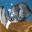

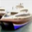

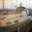

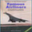

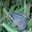

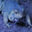

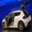

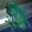

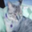

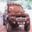

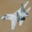

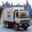

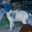

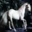

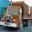

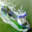

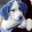

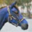

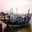

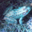

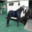

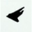

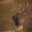

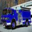

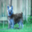

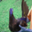

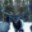

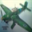

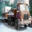

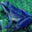

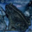

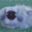

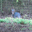

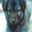

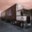

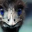

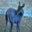

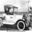

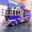

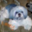

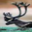

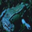

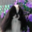

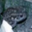

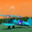

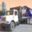

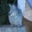

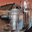

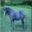

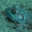

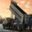

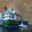

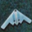

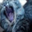

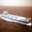

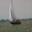

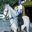

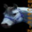

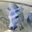

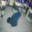

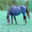

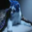

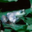

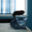

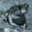

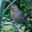

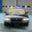

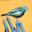

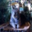

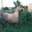

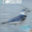

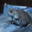

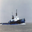

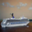

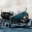

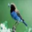

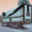

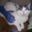

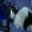

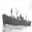

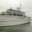

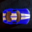

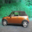

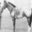

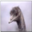

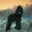

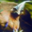

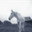

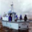

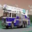

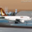

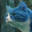

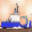

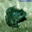

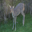

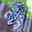

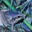

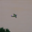

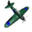

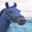

In [ ]:
from IPython.display import display, Image

for data in test_dataset[:100]:
    bimg = data[0].copy()
    label = data[1]
    bimg *=255.
    img = bimg.transpose(1,2,0)
    #display_cv_image(img, '.png')
    decoded_bytes = cv2.imencode('.png', img)[1].tobytes()
    display(Image(data=decoded_bytes)) 



## 課題　
###以下の課題に取り組みましょう
1  ネットワーク構造を変えて実験しましょう

2  最適化の方法をAdam以外に変えて実験しましょう

3  エポック数やミニバッチサイズを変えて実験しましょう

4  GPUの有無による速度の差を比較しましょう
